In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [152]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import loadmat


file = loadmat('/Users/samsuidman/Desktop/neurophysics/machine_learning/mnistAll.mat') 

train_images = file['mnist']['train_images'][0][0]
test_images = file['mnist']['test_images'][0][0]
train_labels = file['mnist']['train_labels'][0][0].transpose()[0]
test_labels = file['mnist']['test_labels'][0][0].transpose()[0]


indices_3 = np.where(train_labels==3)[0]
indices_7 = np.where(train_labels==7)[0]
X3 = train_images[:,:,indices_3]
X7 = train_images[:,:,indices_7]
n3 = np.size(X3,2)
n7 = np.size(X7,2)
X3 = np.reshape(X3,[784,n3])
X7 = np.reshape(X7,[784,n7])
X3 = X3/np.max((np.max(np.concatenate(X3)),np.max(np.concatenate(X7))))
X7 = X7/np.max((np.max(np.concatenate(X3)),np.max(np.concatenate(X7))))

#These are the important matrices and arrays in the end. X3 consists of P=6131 images of the number 3. X[3] for example is the 4th image. Each image has 28x28=784 pixels. To make sure that an image doesn't only consists of zeros, before each image is a 1 added. 
X3 = (np.insert(X3,0,1,axis=0)).transpose() #shape = (6131,785)
X7 = (np.insert(X3,0,1,axis=0)).transpose() #shape = (6265,785)
t3 = np.zeros([1,n3])[0] #length = 6131
t7 = np.ones([1,n7])[0] #length = 6265


#these are the functions 
def y(w,X):
    y = np.array([1/(1+np.exp(-np.dot(w,x))) for x in X])
    return y 

def E(w,X,t):
    Ew = np.array([-1/len(x)*(t*np.log(y(w,x)+(1-t)*np.log(1-y(w,x)))) for x in X])
    return Ew

def dE(w,X,t):
    dE = np.array([1/len(x)*(y(w,x)-t)*x for x in X])
    return dE


w = np.random.normal(0,1,size=X3[0].shape)




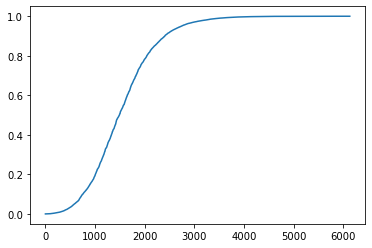

In [165]:
plt.plot(np.sort(y(w,X3)))

In [143]:
X3.shape

(6131, 785)